# Exploratory Data Analysis: Collected HTML Fragments

This notebook analyzes the collected HTML fragments from `data/seeds/candidates/` to:
1. **Context window sizing** - Check if fragments fit within 32k tokens (preferably 8k-24k)
2. **Text proportion** - Analyze the ratio of extracted text to full HTML length (by characters)
3. **Quality metrics** - Token distributions, size distributions across schema types

**Note**: Token counts use the Qwen2.5-0.5B tokenizer to match the target model for fine-tuning.

## Imports

In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
import sys
from bs4 import BeautifulSoup

# Add project root to path for src imports
sys.path.insert(0, str(Path('..').resolve()))
from src.qwen_utils import count_tokens

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

%matplotlib inline

print('All libraries imported successfully!')
print('Using Qwen2.5-0.5B tokenizer for token counting')

## Load HTML Fragments and Annotations

In [2]:
# Find all HTML files
candidates_dir = Path('../data/seeds/candidates')
html_files = sorted(candidates_dir.glob('*.html'))

print(f'Found {len(html_files)} HTML files')

# Parse schema types
schema_counts = Counter()
for html_file in html_files:
    schema_type = html_file.stem.split('_')[0]
    schema_counts[schema_type] += 1

print(f'\nSchema type distribution:')
for schema_type, count in schema_counts.most_common():
    print(f'  {schema_type}: {count}')

Found 208 HTML files

Schema type distribution:
  product: 74
  recipe: 60
  event: 26
  pricing: 21
  person: 19
  job: 8


## Calculate Token Counts and Text Proportions

In [3]:
# Analyze each HTML fragment
print('Analyzing HTML fragments...')
analysis_data = []

for i, html_file in enumerate(html_files):
    if (i + 1) % 50 == 0:
        print(f'  Processed {i + 1}/{len(html_files)} files...')
    
    # Parse schema type and ID
    parts = html_file.stem.split('_')
    schema_type = parts[0]
    fragment_id = '_'.join(parts[1:])
    
    # Read HTML
    with open(html_file, 'r', encoding='utf-8', errors='replace') as f:
        html = f.read()
    
    # Extract text using BeautifulSoup
    soup = BeautifulSoup(html, 'html.parser')
    extracted_text = soup.get_text(separator=' ', strip=True)
    
    # Token counts using Qwen tokenizer
    html_tokens = count_tokens(html)
    text_tokens = count_tokens(extracted_text)
    
    # Character counts
    html_chars = len(html)
    text_chars = len(extracted_text)
    
    # Text proportion (chars)
    text_proportion = text_chars / html_chars if html_chars > 0 else 0
    
    analysis_data.append({
        'file': html_file.name,
        'schema_type': schema_type,
        'fragment_id': fragment_id,
        'html_tokens': html_tokens,
        'text_tokens': text_tokens,
        'html_chars': html_chars,
        'text_chars': text_chars,
        'text_proportion': text_proportion,
        'tokens_per_char': html_tokens / html_chars if html_chars > 0 else 0
    })

df = pd.DataFrame(analysis_data)

print(f'\nAnalysis complete for {len(df)} fragments')
print(f'DataFrame shape: {df.shape}')
df.head()

Analyzing HTML fragments...
  Processed 50/208 files...


Token indices sequence length is longer than the specified maximum sequence length for this model (178455 > 131072). Running this sequence through the model will result in indexing errors


  Processed 100/208 files...
  Processed 150/208 files...
  Processed 200/208 files...

Analysis complete for 208 fragments
DataFrame shape: (208, 9)


,file,schema_type,fragment_id,html_tokens,text_tokens,html_chars,text_chars,text_proportion,tokens_per_char
0,event_054f78d4.html,event,054f78d4,1453,83,4410,222,0.050340,0.329478
1,event_1415218c.html,event,1415218c,20832,264,42056,678,0.016121,0.495340
2,event_17dd6767.html,event,17dd6767,1673,92,5152,269,0.052213,0.324728
3,event_24eee0a7.html,event,24eee0a7,1740,72,5484,284,0.051787,0.317287
4,event_2b0c4282.html,event,2b0c4282,1785,104,5495,318,0.057871,0.324841


## 1. Token Count Distribution (Context Window Analysis)

In [4]:
# Summary statistics
print('HTML Token Count Statistics (Qwen2.5-0.5B tokenizer):')
print(f'  Min: {df["html_tokens"].min():,} tokens')
print(f'  Max: {df["html_tokens"].max():,} tokens')
print(f'  Mean: {df["html_tokens"].mean():,.0f} tokens')
print(f'  Median: {df["html_tokens"].median():,.0f} tokens')
print(f'  25th percentile: {df["html_tokens"].quantile(0.25):,.0f} tokens')
print(f'  75th percentile: {df["html_tokens"].quantile(0.75):,.0f} tokens')

# Context window limits
print(f'\nContext Window Fit Analysis:')
context_limits = {
    '8K': 8192,
    '16K': 16384,
    '24K': 24576,
    '32K': 32768,
}

for name, limit in context_limits.items():
    within = (df['html_tokens'] <= limit).sum()
    pct = within / len(df) * 100
    print(f'  Within {name} ({limit:,} tokens): {within}/{len(df)} ({pct:.1f}%)')

# Preferred range (8k-24k)
preferred = ((df['html_tokens'] >= 8192) & (df['html_tokens'] <= 24576)).sum()
preferred_pct = preferred / len(df) * 100
print(f'\n  In preferred range (8K-24K): {preferred}/{len(df)} ({preferred_pct:.1f}%)')

HTML Token Count Statistics (Qwen2.5-0.5B tokenizer):
  Min: 724 tokens
  Max: 178,872 tokens
  Mean: 41,187 tokens
  Median: 20,732 tokens
  25th percentile: 13,197 tokens
  75th percentile: 63,072 tokens

Context Window Fit Analysis:
  Within 8K (8,192 tokens): 46/208 (22.1%)
  Within 16K (16,384 tokens): 77/208 (37.0%)
  Within 24K (24,576 tokens): 115/208 (55.3%)
  Within 32K (32,768 tokens): 121/208 (58.2%)

  In preferred range (8K-24K): 69/208 (33.2%)


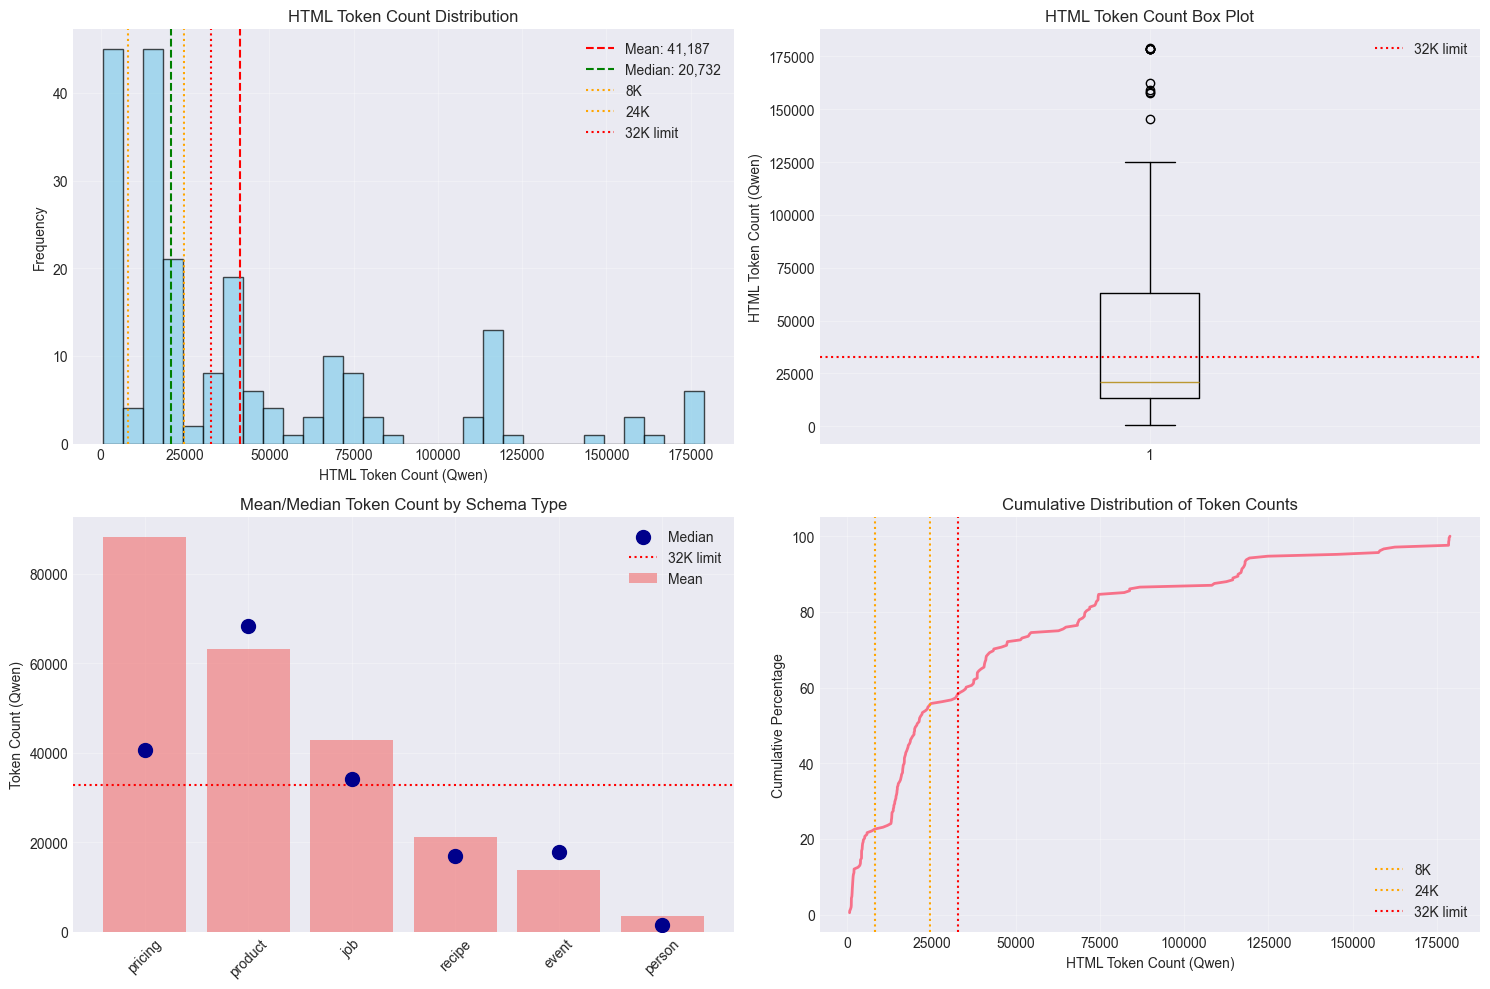

In [5]:
# Visualize token distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histogram
axes[0, 0].hist(df['html_tokens'], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 0].axvline(df['html_tokens'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {df["html_tokens"].mean():,.0f}')
axes[0, 0].axvline(df['html_tokens'].median(), color='green', linestyle='--', 
                   label=f'Median: {df["html_tokens"].median():,.0f}')
axes[0, 0].axvline(8192, color='orange', linestyle=':', label='8K')
axes[0, 0].axvline(24576, color='orange', linestyle=':', label='24K')
axes[0, 0].axvline(32768, color='red', linestyle=':', label='32K limit')
axes[0, 0].set_xlabel('HTML Token Count (Qwen)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('HTML Token Count Distribution')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Box plot
axes[0, 1].boxplot(df['html_tokens'], vert=True)
axes[0, 1].set_ylabel('HTML Token Count (Qwen)')
axes[0, 1].set_title('HTML Token Count Box Plot')
axes[0, 1].axhline(32768, color='red', linestyle=':', label='32K limit')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# By schema type
schema_tokens = df.groupby('schema_type')['html_tokens'].agg(['mean', 'median', 'min', 'max'])
schema_tokens = schema_tokens.sort_values('mean', ascending=False)
x_pos = np.arange(len(schema_tokens))
axes[1, 0].bar(x_pos, schema_tokens['mean'], color='lightcoral', alpha=0.7, label='Mean')
axes[1, 0].scatter(x_pos, schema_tokens['median'], color='darkblue', s=100, zorder=3, label='Median')
axes[1, 0].axhline(32768, color='red', linestyle=':', label='32K limit')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(schema_tokens.index, rotation=45)
axes[1, 0].set_ylabel('Token Count (Qwen)')
axes[1, 0].set_title('Mean/Median Token Count by Schema Type')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Cumulative distribution
sorted_tokens = np.sort(df['html_tokens'])
cumulative = np.arange(1, len(sorted_tokens) + 1) / len(sorted_tokens) * 100
axes[1, 1].plot(sorted_tokens, cumulative, linewidth=2)
axes[1, 1].axvline(8192, color='orange', linestyle=':', label='8K')
axes[1, 1].axvline(24576, color='orange', linestyle=':', label='24K')
axes[1, 1].axvline(32768, color='red', linestyle=':', label='32K limit')
axes[1, 1].set_xlabel('HTML Token Count (Qwen)')
axes[1, 1].set_ylabel('Cumulative Percentage')
axes[1, 1].set_title('Cumulative Distribution of Token Counts')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Text Proportion Analysis

In [6]:
# Summary statistics for text proportion
print('Text Proportion Statistics (text_chars / html_chars):')
print(f'  Min: {df["text_proportion"].min():.3f}')
print(f'  Max: {df["text_proportion"].max():.3f}')
print(f'  Mean: {df["text_proportion"].mean():.3f}')
print(f'  Median: {df["text_proportion"].median():.3f}')
print(f'  25th percentile: {df["text_proportion"].quantile(0.25):.3f}')
print(f'  75th percentile: {df["text_proportion"].quantile(0.75):.3f}')

# By schema type
print(f'\nText Proportion by Schema Type:')
schema_text_prop = df.groupby('schema_type')['text_proportion'].agg(['mean', 'median', 'min', 'max'])
schema_text_prop = schema_text_prop.sort_values('mean', ascending=False)
print(schema_text_prop.round(3))

Text Proportion Statistics (text_chars / html_chars):
  Min: 0.016
  Max: 0.913
  Mean: 0.139
  Median: 0.095
  25th percentile: 0.058
  75th percentile: 0.137

Text Proportion by Schema Type:
              mean  median    min    max
schema_type                             
person       0.535   0.559  0.061  0.913
job          0.165   0.117  0.048  0.437
recipe       0.126   0.132  0.052  0.231
product      0.090   0.090  0.029  0.306
event        0.069   0.062  0.016  0.112
pricing      0.064   0.055  0.037  0.136


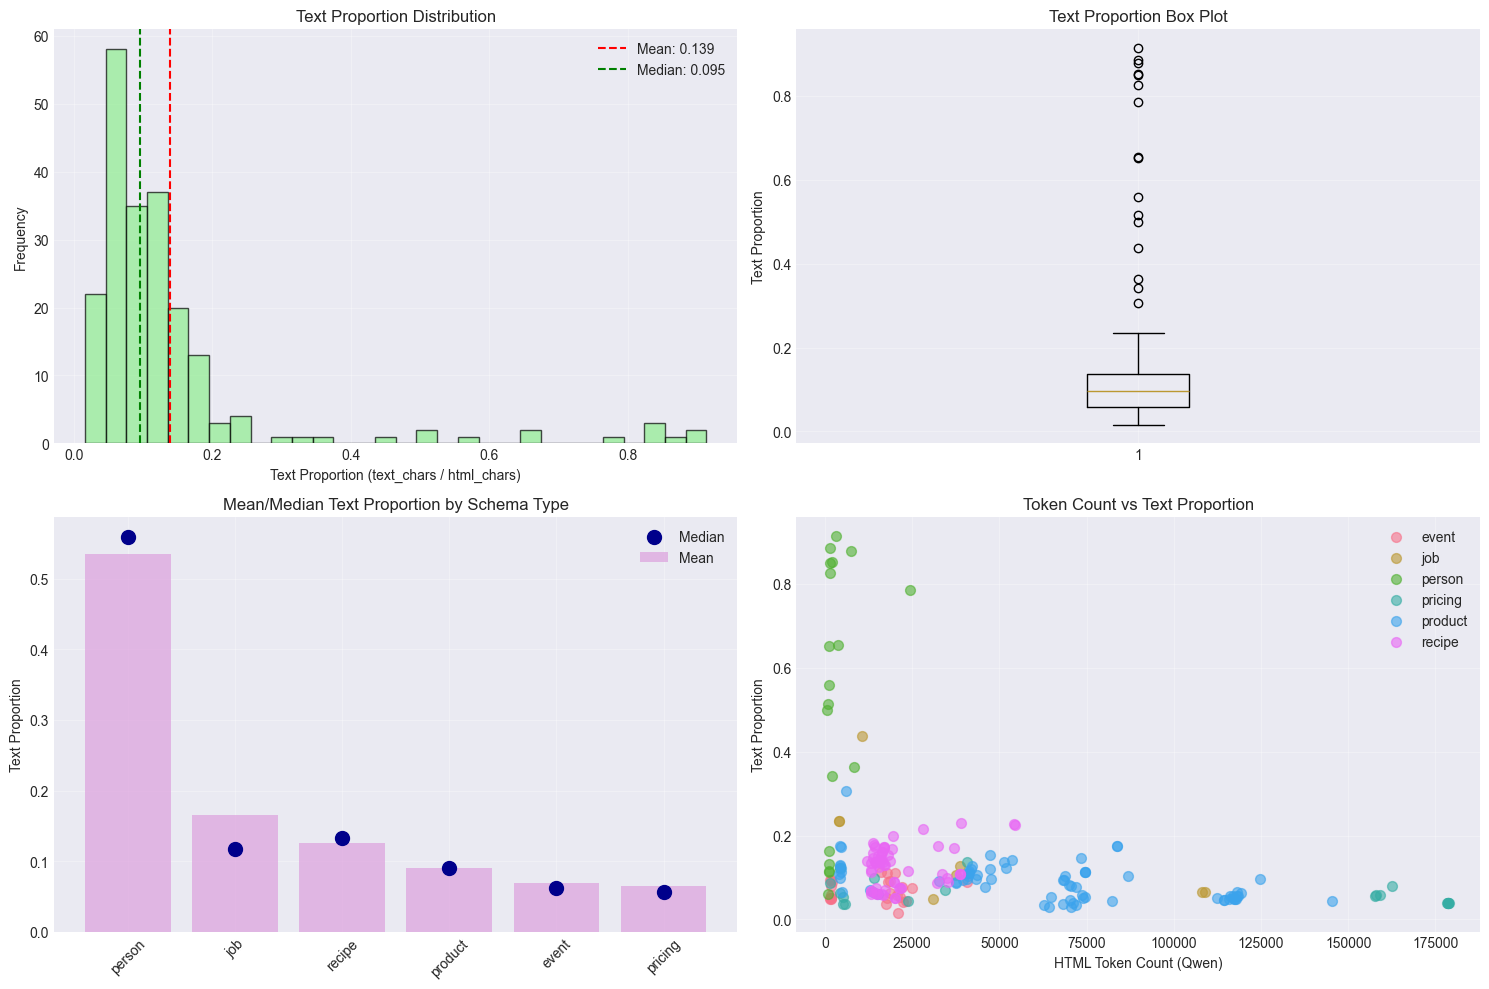

In [7]:
# Visualize text proportion
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histogram
axes[0, 0].hist(df['text_proportion'], bins=30, edgecolor='black', alpha=0.7, color='lightgreen')
axes[0, 0].axvline(df['text_proportion'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {df["text_proportion"].mean():.3f}')
axes[0, 0].axvline(df['text_proportion'].median(), color='green', linestyle='--', 
                   label=f'Median: {df["text_proportion"].median():.3f}')
axes[0, 0].set_xlabel('Text Proportion (text_chars / html_chars)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Text Proportion Distribution')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Box plot
axes[0, 1].boxplot(df['text_proportion'], vert=True)
axes[0, 1].set_ylabel('Text Proportion')
axes[0, 1].set_title('Text Proportion Box Plot')
axes[0, 1].grid(True, alpha=0.3)

# By schema type
x_pos = np.arange(len(schema_text_prop))
axes[1, 0].bar(x_pos, schema_text_prop['mean'], color='plum', alpha=0.7, label='Mean')
axes[1, 0].scatter(x_pos, schema_text_prop['median'], color='darkblue', s=100, zorder=3, label='Median')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(schema_text_prop.index, rotation=45)
axes[1, 0].set_ylabel('Text Proportion')
axes[1, 0].set_title('Mean/Median Text Proportion by Schema Type')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Scatter: tokens vs text proportion
for schema_type in df['schema_type'].unique():
    subset = df[df['schema_type'] == schema_type]
    axes[1, 1].scatter(subset['html_tokens'], subset['text_proportion'], 
                       label=schema_type, alpha=0.6, s=50)
axes[1, 1].set_xlabel('HTML Token Count (Qwen)')
axes[1, 1].set_ylabel('Text Proportion')
axes[1, 1].set_title('Token Count vs Text Proportion')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Schema Type Comparison

In [8]:
# Summary table by schema type
summary_by_schema = df.groupby('schema_type').agg({
    'html_tokens': ['count', 'mean', 'median', 'min', 'max'],
    'text_proportion': ['mean', 'median'],
    'html_chars': ['mean', 'median']
}).round(2)

print('Summary Statistics by Schema Type:\n')
print(summary_by_schema)

Summary Statistics by Schema Type:

            html_tokens                                   text_proportion  \
                  count      mean   median    min     max            mean   
schema_type                                                                 
event                26  13781.77  17777.5   1453   40698            0.07   
job                   8  42850.25  34187.0   3971  108964            0.16   
person               19   3448.68   1410.0    724   24428            0.53   
pricing              21  88231.81  40609.0   1497  178872            0.06   
product              74  63235.65  68352.5   3934  145415            0.09   
recipe               60  21133.72  16941.5  11989   54544            0.13   

                   html_chars            
            median       mean    median  
schema_type                              
event         0.06   28072.31   34720.0  
job           0.12   94098.75  105610.0  
person        0.56   11937.79    5123.0  
pricing       0.06

In [9]:
# Detailed table showing context window fit by schema type
context_fit_by_schema = []

for schema_type in df['schema_type'].unique():
    subset = df[df['schema_type'] == schema_type]
    total = len(subset)
    
    within_8k = (subset['html_tokens'] <= 8192).sum()
    within_16k = (subset['html_tokens'] <= 16384).sum()
    within_24k = (subset['html_tokens'] <= 24576).sum()
    within_32k = (subset['html_tokens'] <= 32768).sum()
    in_preferred = ((subset['html_tokens'] >= 8192) & (subset['html_tokens'] <= 24576)).sum()
    
    context_fit_by_schema.append({
        'schema_type': schema_type,
        'total': total,
        '≤8K': f"{within_8k} ({within_8k/total*100:.1f}%)",
        '≤16K': f"{within_16k} ({within_16k/total*100:.1f}%)",
        '≤24K': f"{within_24k} ({within_24k/total*100:.1f}%)",
        '≤32K': f"{within_32k} ({within_32k/total*100:.1f}%)",
        '8K-24K': f"{in_preferred} ({in_preferred/total*100:.1f}%)"
    })

context_fit_df = pd.DataFrame(context_fit_by_schema)
print('\nContext Window Fit by Schema Type:\n')
print(context_fit_df.to_string(index=False))


Context Window Fit by Schema Type:

schema_type  total        ≤8K       ≤16K        ≤24K        ≤32K     8K-24K
      event     26 10 (38.5%) 11 (42.3%)  24 (92.3%)  25 (96.2%) 14 (53.8%)
        job      8  2 (25.0%)  3 (37.5%)   3 (37.5%)   4 (50.0%)  1 (12.5%)
     person     19 17 (89.5%) 18 (94.7%) 19 (100.0%) 19 (100.0%)  2 (10.5%)
    pricing     21  7 (33.3%)  8 (38.1%)   9 (42.9%)   9 (42.9%)   2 (9.5%)
    product     74 10 (13.5%) 13 (17.6%)  13 (17.6%)  14 (18.9%)   3 (4.1%)
     recipe     60   0 (0.0%) 24 (40.0%)  47 (78.3%)  50 (83.3%) 47 (78.3%)


## 4. Outliers and Quality Issues

In [10]:
# Fragments exceeding 32k tokens
exceeds_32k = df[df['html_tokens'] > 32768].sort_values('html_tokens', ascending=False)
print(f'Fragments exceeding 32K tokens: {len(exceeds_32k)}')
if len(exceeds_32k) > 0:
    print('\nTop fragments exceeding 32K:')
    print(exceeds_32k[['file', 'schema_type', 'html_tokens', 'text_proportion']].head(10))

# Very small fragments (< 1k tokens)
very_small = df[df['html_tokens'] < 1000].sort_values('html_tokens')
print(f'\n\nVery small fragments (< 1K tokens): {len(very_small)}')
if len(very_small) > 0:
    print('\nSmallest fragments:')
    print(very_small[['file', 'schema_type', 'html_tokens', 'text_proportion']].head(10))

# Low text proportion (< 0.1)
low_text_prop = df[df['text_proportion'] < 0.1].sort_values('text_proportion')
print(f'\n\nFragments with low text proportion (< 0.1): {len(low_text_prop)}')
if len(low_text_prop) > 0:
    print('\nLowest text proportions:')
    print(low_text_prop[['file', 'schema_type', 'html_tokens', 'text_proportion']].head(10))

Fragments exceeding 32K tokens: 87

Top fragments exceeding 32K:
                           file schema_type  html_tokens  text_proportion
68  pricing_table_b4d2dc6c.html     pricing       178872         0.038524
65  pricing_table_ab905f28.html     pricing       178614         0.038558
66  pricing_table_b07794bf.html     pricing       178596         0.038569
61  pricing_table_6603a436.html     pricing       178488         0.038572
58  pricing_table_3c3f063e.html     pricing       178475         0.038570
53  pricing_table_003c2212.html     pricing       178455         0.038572
56  pricing_table_1c48e2fa.html     pricing       162509         0.079175
62  pricing_table_80745664.html     pricing       159221         0.057421
70  pricing_table_d09e5d53.html     pricing       158076         0.057945
59  pricing_table_50d878f1.html     pricing       157653         0.055457


Very small fragments (< 1K tokens): 2

Smallest fragments:
                    file schema_type  html_tokens  text_prop

## 5. Export Analysis Results

In [11]:
# Save analysis to CSV
output_path = Path('../data/seeds/fragment_analysis.csv')
df.to_csv(output_path, index=False)
print(f'Analysis saved to {output_path}')

# Print final summary
print('\n' + '='*60)
print('FINAL SUMMARY')
print('='*60)
print(f'Total fragments analyzed: {len(df)}')
print(f'\nToken count stats (Qwen2.5-0.5B tokenizer):')
print(f'  Mean: {df["html_tokens"].mean():,.0f} tokens')
print(f'  Median: {df["html_tokens"].median():,.0f} tokens')
print(f'  Range: {df["html_tokens"].min():,} - {df["html_tokens"].max():,} tokens')
print(f'\nContext window fit:')
print(f'  Within 32K: {(df["html_tokens"] <= 32768).sum()}/{len(df)} ({(df["html_tokens"] <= 32768).sum()/len(df)*100:.1f}%)')
print(f'  In preferred range (8K-24K): {((df["html_tokens"] >= 8192) & (df["html_tokens"] <= 24576)).sum()}/{len(df)} ({((df["html_tokens"] >= 8192) & (df["html_tokens"] <= 24576)).sum()/len(df)*100:.1f}%)')
print(f'\nText proportion stats:')
print(f'  Mean: {df["text_proportion"].mean():.3f}')
print(f'  Median: {df["text_proportion"].median():.3f}')
print(f'  Range: {df["text_proportion"].min():.3f} - {df["text_proportion"].max():.3f}')

Analysis saved to ../data/seeds/fragment_analysis.csv

FINAL SUMMARY
Total fragments analyzed: 208

Token count stats (Qwen2.5-0.5B tokenizer):
  Mean: 41,187 tokens
  Median: 20,732 tokens
  Range: 724 - 178,872 tokens

Context window fit:
  Within 32K: 121/208 (58.2%)
  In preferred range (8K-24K): 69/208 (33.2%)

Text proportion stats:
  Mean: 0.139
  Median: 0.095
  Range: 0.016 - 0.913
